In [133]:
from valurap import path_planning
import imp
import seaborn as sns

imp.reload(path_planning)

%matplotlib notebook
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt



In [ ]:
errors = []
solve = path_planning.solve_model_simple(0, 1370000-50000, 5000, 50, 300, errors)
solve
#df = pd.DataFrame(errors)
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=df["delta_v"]*df["delta_v"]+df["jerk"]*df["jerk"])
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=abs(df["jerk"]/250000))
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=20*3*2+1, weights=abs(df["end_a"]/700000000) + abs(df["jerk"]/250000))
#print(hist[0])

#fig, ax = plt.subplots(figsize=(20, 10))
#im = ax.imshow(hist[0])
#cbar = fig.colorbar(im)

In [135]:
from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 100
v = 500

for i in range(0, 5):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v * 0.7])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v * 0.7])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
        
path.append([x, y, 0])
    
print(path)

path_k = [1.0] * len(path)
attempts = 0
while True:
    plan_errors = []
    real_path = []
    for i, (x, y, speed) in enumerate(path):
        real_path.append((x, y, speed * path_k[i]))
        
    print(real_path)
    pr_opt = path_planning.plan_path([0, 0], real_path, fatal=False, plan_errors = plan_errors)
    if plan_errors:
        i, et, vals, target = plan_errors[0]
        print(plan_errors)
        if vals is None:
            raise RuntimeError("unknown error")
        min_val = min(abs(array(vals)))
        assert abs(min_val) < target
        k = abs(target/min_val) * 1.1
        adj_i = i
        adj_part = 0
        if et == "out_avail_exit":
            adj_i = i
            adj_part = 1
        elif et == "cur_avail_exit":
            adj_i = i
            adj_part = 1
        elif et == "in_avail_enter":
            adj_i = i - 1
            adj_part = 1
        elif et == "cur_avail_enter":
            adj_i = i
            adj_part = 0
        elif et == "middle_delta_in":
            adj_i = i - 1
            adj_part = 1
        elif et == "middle_delta_cur":
            adj_i = i
            adj_part = 0
        else:
            raise RuntimeError()

            
        print("adjust segment {} on {}/{} (min: {} target: {})".format(adj_i, k, et, min_val, target))
        if adj_i == 0:
            start_x = 0
            start_y = 0
        else:
            start_x, start_y, _ = path[adj_i -1]
        end_x, end_y, speed = path[adj_i]
            
        if abs(start_x - end_x) > 10:
            split_k = abs(5.0 / (end_x - start_x))
        elif abs(start_y - end_y) > 10:
            split_k = abs(5.0 / (end_y - start_y))
        else:
            split_k = None
            
        if split_k is not None:
            if adj_part == 1:
                split_k = 1 - split_k

            split_x = start_x + (end_x - start_x) * split_k
            split_y = start_y + (end_y - start_y) * split_k
            print("before path", path)
            print("before path_k", path_k)
            path = path[:adj_i] + [[split_x, split_y, speed], [end_x, end_y, speed]] + path[adj_i + 1:]
            path_k = path_k[:adj_i + 1] + path_k[adj_i:]
            adj_i = adj_i + adj_part
            print("after path", path)
            print("after path_k", path_k)
            
        path_k[adj_i] = path_k[adj_i] / k
        print("new path_k", path_k)
        attempts += 1
        if attempts == len(path) * 3:
            break
    else:
        break

import warnings
warnings.filterwarnings("error")

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)

print(plan_errors)
print(path_k)



[[200.0, 0, 500], [200.0, -200.0, 350.0], [2.5, -200.0, 500], [2.5, -2.5, 350.0], [197.5, -2.5, 500], [197.5, -197.5, 350.0], [5.0, -197.5, 500], [5.0, -5.0, 350.0], [195.0, -5.0, 500], [195.0, -195.0, 350.0], [7.5, -195.0, 500], [7.5, -7.5, 350.0], [192.5, -7.5, 500], [192.5, -192.5, 350.0], [10.0, -192.5, 500], [10.0, -10.0, 350.0], [190.0, -10.0, 500], [190.0, -190.0, 350.0], [12.5, -190.0, 500], [12.5, -12.5, 350.0], [12.5, -12.5, 0]]
[(200.0, 0, 500.0), (200.0, -200.0, 350.0), (2.5, -200.0, 500.0), (2.5, -2.5, 350.0), (197.5, -2.5, 500.0), (197.5, -197.5, 350.0), (5.0, -197.5, 500.0), (5.0, -5.0, 350.0), (195.0, -5.0, 500.0), (195.0, -195.0, 350.0), (7.5, -195.0, 500.0), (7.5, -7.5, 350.0), (192.5, -7.5, 500.0), (192.5, -192.5, 350.0), (10.0, -192.5, 500.0), (10.0, -10.0, 350.0), (190.0, -10.0, 500.0), (190.0, -190.0, 350.0), (12.5, -190.0, 500.0), (12.5, -12.5, 350.0), (12.5, -12.5, 0.0)]
x: in [0 0] in_target [0 0] cur_target [200.   0.]
speeds: prev [0 0] current [499.9999975  

      fun: 0.009273603836741782
 hess_inv: array([[0.75907471, 0.02776987],
       [0.02776987, 0.0010213 ]])
      jac: array([0.00129575, 0.00574907])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 402
      nit: 9
     njev: 98
   status: 2
  success: False
        x: array([-0.26770684,  0.33320979])
old 48444946 -580179
new 48315256 -582112
cur_target: [195.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 167, 'plato_t': 231}
sol_x: {'accel_j': 48315256, 'accel_jj': -582112, 'plato_v': 3444945.4566955566, 'accel_x': 3310.8735741862456, 'accel_middle_x': 598.5529197786832, 'plato_x': 9264.126425803099}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.71383806]), 1.0)]
adjust segment 0 on 1.540965737752326/out_avail_exit (min: 0.7138380646960233 target: 1.0)
before path [[195.0, 0.0, 500], [200.0, 0, 500], [200.0,

enter_delta_v: [499.99999714   0.        ]
enter_time: 0.16666666571428573
enter_a: [3000.    0.]
enter_delta_x: [41.66666619  0.        ]
enter_t_first: [0.08333333 0.        ]
enter_t_second: [0.08333333 0.16666667]
enter_need_first: [0. 0.]
enter_need_second: [41.66666627  0.        ]
exit_delta_v: [-370.0124902    0.       ]
exit_time: 0.12333749673474896
exit_a: [-2999.97567669     0.        ]
exit_delta_x: [38.85072587  0.        ]
exit_t_first: [0.06166925 0.        ]
exit_t_second: [0.06166825 0.1233375 ]
exit_need_first: [30.83462409  0.        ]
exit_need_second: [8.01610184 0.        ]
out_avail exit assert: [0.31187228]
cur_target: [175.   0.]
decel_end: [183.01610184   0.        ]
decel_start: [144.16537591   0.        ]
accel_start: [0 0]
target_x: [144.16537591   0.        ]
args_x: {'in_v': 0, 'target_v': 3435974, 'target_x': 11533, 'accel_t': 167, 'plato_t': 205}
      fun: 0.009476604697027997
 hess_inv: array([[3.9181098 , 3.95050557],
       [3.95050557, 4.00027719]

cur_target: [160.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 167, 'plato_t': 176}
sol_x: {'accel_j': 48446830, 'accel_jj': -583699, 'plato_v': 3451650.443664551, 'accel_x': 3319.88004868311, 'accel_middle_x': 600.1823448631427, 'plato_x': 7072.119951305921}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.29912727]), 1.0)]
adjust segment 0 on 3.6773644637910086/out_avail_exit (min: 0.29912727194464866 target: 1.0)
before path [[160.0, 0.0, 500], [165.0, 0.0, 500], [170.0, 0.0, 500], [175.0, 0.0, 500], [180.0, 0.0, 500], [185.0, 0.0, 500], [190.0, 0.0, 500], [195.0, 0.0, 500], [200.0, 0, 500], [200.0, -200.0, 350.0], [2.5, -200.0, 500], [2.5, -2.5, 350.0], [197.5, -2.5, 500], [197.5, -197.5, 350.0], [5.0, -197.5, 500], [5.0, -5.0, 350.0], [195.0, -5.0, 500], [195.0, -195.0, 350.0], [7.5, -195.0, 500], [7.5, -7.5, 350.0], [192.5, -7.5, 500], [192.5, -1

      fun: 0.013443511754397097
 hess_inv: array([[0.04533991, 0.00730324],
       [0.00730324, 0.00117645]])
      jac: array([ 0.00280507, -0.0040388 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 598
      nit: 8
     njev: 144
   status: 2
  success: False
        x: array([-0.10576001,  0.4961137 ])
old 48444946 -580179
new 48393711 -583057
cur_target: [145.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 167, 'plato_t': 146}
sol_x: {'accel_j': 48393711, 'accel_jj': -583057, 'plato_v': 3448769.8034210205, 'accel_x': 3316.251160038419, 'accel_middle_x': 599.5249374370459, 'plato_x': 5861.748839955183}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.30212447]), 1.0)]
adjust segment 0 on 3.6408835575490492/out_avail_exit (min: 0.30212446583721353 target: 1.0)
before path [[145.0, 0.0, 500], [150.0, 0.0, 500], [

enter_t_second: [0.08333333 0.16666667]
enter_need_first: [0. 0.]
enter_need_second: [41.66666613  0.        ]
exit_delta_v: [-363.10218854    0.        ]
exit_time: 0.12103406284646724
exit_a: [-2999.97521379     0.        ]
exit_delta_x: [38.54334597  0.        ]
exit_t_first: [0.06051753 0.        ]
exit_t_second: [0.06051653 0.12103406]
exit_need_first: [30.25876557  0.        ]
exit_need_second: [8.28458046 0.        ]
out_avail exit assert: [0.30176543]
cur_target: [135.   0.]
decel_end: [143.28458046   0.        ]
decel_start: [104.74123443   0.        ]
accel_start: [0 0]
target_x: [104.74123443   0.        ]
args_x: {'in_v': 0, 'target_v': 3435974, 'target_x': 8379, 'accel_t': 167, 'plato_t': 126}
      fun: 0.014938961746952025
 hess_inv: array([[4.07802208, 4.13207574],
       [4.13207574, 4.21328132]])
      jac: array([-0.00041016,  0.00038238])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 680
      nit: 15
     njev: 168
   status:

cur_target: [120.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 167, 'plato_t': 96}
sol_x: {'accel_j': 48314140, 'accel_jj': -582074, 'plato_v': 3462876.9478149414, 'accel_x': 3310.9334304679546, 'accel_middle_x': 598.5471093801209, 'plato_x': 3870.066569538721}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.30148421]), 1.0)]
adjust segment 0 on 3.648615658150287/out_avail_exit (min: 0.30148420745353577 target: 1.0)
before path [[120.0, 0.0, 500], [125.0, 0.0, 500], [130.0, 0.0, 500], [135.0, 0.0, 500], [140.0, 0.0, 500], [145.0, 0.0, 500], [150.0, 0.0, 500], [155.0, 0.0, 500], [160.0, 0.0, 500], [165.0, 0.0, 500], [170.0, 0.0, 500], [175.0, 0.0, 500], [180.0, 0.0, 500], [185.0, 0.0, 500], [190.0, 0.0, 500], [195.0, 0.0, 500], [200.0, 0, 500], [200.0, -200.0, 350.0], [2.5, -200.0, 500], [2.5, -2.5, 350.0], [197.5, -2.5, 500], [197.5, -197.5, 350.0], [

i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.30151765]), 1.0)]
adjust segment 0 on 3.6482109451281834/out_avail_exit (min: 0.3015176525000395 target: 1.0)
before path [[110.0, 0.0, 500], [115.0, 0.0, 500], [120.0, 0.0, 500], [125.0, 0.0, 500], [130.0, 0.0, 500], [135.0, 0.0, 500], [140.0, 0.0, 500], [145.0, 0.0, 500], [150.0, 0.0, 500], [155.0, 0.0, 500], [160.0, 0.0, 500], [165.0, 0.0, 500], [170.0, 0.0, 500], [175.0, 0.0, 500], [180.0, 0.0, 500], [185.0, 0.0, 500], [190.0, 0.0, 500], [195.0, 0.0, 500], [200.0, 0, 500], [200.0, -200.0, 350.0], [2.5, -200.0, 500], [2.5, -2.5, 350.0], [197.5, -2.5, 500], [197.5, -197.5, 350.0], [5.0, -197.5, 500], [5.0, -5.0, 350.0], [195.0, -5.0, 500], [195.0, -195.0, 350.0], [7.5, -195.0, 500], [7.5, -7.5, 350.0], [192.5, -7.5, 500], [192.5, -192.5, 350.0], [10.0, -192.5, 500], [10.0, -10.0, 350.0], [190.0, -10.0, 500], [190.0, -190.0, 350.0], [12.5, -190.0, 500], [12.5, -12.5, 350.0], [12.5, -12.5, 0]]
before path_k [1.0, 0.27415707

exit_delta_v: [-362.94062748    0.        ]
exit_time: 0.12098020915972858
exit_a: [-2999.97520276     0.        ]
exit_delta_x: [38.5359689  0.       ]
exit_t_first: [0.0604906 0.       ]
exit_t_second: [0.0604896  0.12098021]
exit_need_first: [30.24530205  0.        ]
exit_need_second: [8.29066691 0.        ]
out_avail exit assert: [0.3015439]
cur_target: [95.  0.]
decel_end: [103.29066691   0.        ]
decel_start: [64.75469795  0.        ]
accel_start: [0 0]
target_x: [64.75469795  0.        ]
args_x: {'in_v': 0, 'target_v': 3435974, 'target_x': 5180, 'accel_t': 167, 'plato_t': 46}
      fun: 0.02253877386220341
 hess_inv: array([[ 9.52375717, 10.50346173],
       [10.50346173, 11.61632644]])
      jac: array([-0.08599837,  0.0336168 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 384
      nit: 6
     njev: 93
   status: 2
  success: False
        x: array([0.31098702, 0.91755601])
old 48444946 -580179
new 48595603 -585502
cur_target: [95. 

avails: prev [0 0] current [80.  0.] next [2.5 0. ]
enter_delta_v: [499.99999375   0.        ]
enter_time: 0.16666666458333337
enter_a: [3000.    0.]
enter_delta_x: [41.66666563  0.        ]
enter_t_first: [0.08333333 0.        ]
enter_t_second: [0.08333333 0.16666666]
enter_need_first: [0. 0.]
enter_need_second: [41.66666571  0.        ]
cur_avail enter assert: [1.92]
exit_delta_v: [-362.93600605    0.        ]
exit_time: 0.12097866868349945
exit_a: [-2999.97520244     0.        ]
exit_delta_x: [38.53575764  0.        ]
exit_t_first: [0.06048983 0.        ]
exit_t_second: [0.06048883 0.12097867]
exit_need_first: [30.24491687  0.        ]
exit_need_second: [8.29084082 0.        ]
out_avail exit assert: [0.30153757]
cur_target: [80.  0.]
decel_end: [88.29084082  0.        ]
decel_start: [49.75508313  0.        ]
accel_start: [0 0]
target_x: [49.75508313  0.        ]
args_x: {'in_v': 0, 'target_v': 3435974, 'target_x': 3980, 'accel_t': 167, 'plato_t': 16}
      fun: 0.1808805149456715
 h

sol_x: {'accel_j': 856293830, 'accel_jj': -214073550, 'plato_v': 188990.85684204102, 'accel_x': 7.9856857873039635, 'accel_middle_x': 0.570406259114975, 'plato_x': 220.01431421614367}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.95192948]), 1.0)]
adjust segment 0 on 1.1555477866094694/out_avail_exit (min: 0.9519294768652935 target: 1.0)
new path_k [0.04720343440160553, 1.0, 0.27412797539900347, 0.2741232965928408, 0.27413081425792746, 0.2741187345153127, 0.27413814456994373, 0.2741069568182177, 0.27415707230291914, 0.27407655223048705, 0.27420595081145366, 0.27399807537963533, 0.27433221033131866, 0.2737956155137893, 0.2746586053065577, 0.2732739327180128, 0.27550406038781083, 0.2719338835860442, 0.2777055656958791, 0.26851848893886576, 0.283520258955793, 0.2599750138772206, 0.2995309795996226, 0.2394320046902625, 0.6489436951782029, 0.09263435690703663, 1.0, 1.0, 1.0, 

      fun: 0.006045036931097921
 hess_inv: array([[146.47339107, 175.62677317],
       [175.62677317, 210.61539765]])
      jac: array([ 0.00859273, -0.00655141])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
      nit: 6
     njev: 74
   status: 2
  success: False
        x: array([-9.56110054,  8.52660254])
old 1297263276 -432421092
new 1173230630 -469291920
cur_target: [5. 0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 6, 'plato_t': 206}
sol_x: {'accel_j': 1173230630, 'accel_jj': -469291920, 'plato_v': 119292.63006591797, 'accel_x': 2.917707639937816, 'accel_middle_x': 0.20840762537943644, 'plato_x': 286.0822923665296}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

Failed to plan full path
[(0, 'out_avail_exit', array([0.93222902]), 1.0)]
adjust segment 0 on 1.1799675605760953/out_avail_exit (min: 0.9322290177731218 target: 1.0)
new path_k [0.02929402996969707, 1.

x: in [0 0] in_target [0 0] cur_target [5. 0.]
speeds: prev [0 0] current [10.35676775  0.        ] next [500.   0.]
avails: prev [0 0] current [5. 0.] next [37.5  0. ]
enter_delta_v: [10.35676775  0.        ]
enter_time: 0.0034522559159588986
enter_a: [3000.    0.]
enter_delta_x: [0.01787711 0.        ]
enter_t_first: [0.00172613 0.        ]
enter_t_second: [0.00172613 0.00345226]
enter_need_first: [0. 0.]
enter_need_second: [0.01787711 0.        ]
exit_delta_v: [489.64323225   0.        ]
exit_time: 0.16321441075070778
exit_a: [2999.98161938    0.        ]
exit_delta_x: [41.64854474  0.        ]
exit_t_first: [0.08160771 0.        ]
exit_t_second: [0.08160671 0.16321441]
exit_need_first: [0.84519205 0.        ]
exit_need_second: [40.80335277  0.        ]
out_avail exit assert: [0.91904212]
cur_target: [5. 0.]
decel_end: [45.80335277  0.        ]
decel_start: [4.15480795 0.        ]
accel_start: [0 0]
target_x: [4.15480795 0.        ]
args_x: {'in_v': 0, 'target_v': 71171, 'target_x':

exit_delta_x: [41.65776957  0.        ]
exit_t_first: [0.08213309 0.        ]
exit_t_second: [0.08213209 0.16426518]
exit_need_first: [0.59172417 0.        ]
exit_need_second: [41.06604549  0.        ]
out_avail exit assert: [0.91316316]
cur_target: [5. 0.]
decel_end: [46.06604549  0.        ]
decel_start: [4.40827583 0.        ]
accel_start: [0 0]
target_x: [4.40827583 0.        ]
args_x: {'in_v': 0, 'target_v': 49509, 'target_x': 353, 'accel_t': 2, 'plato_t': 611}
      fun: 0.0001677604858291073
 hess_inv: array([[ 7.47920830e-06, -8.08913791e-07],
       [-8.08913791e-07,  2.43104799e-04]])
      jac: array([0.00040003, 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 981
      nit: 17
     njev: 242
   status: 2
  success: False
        x: array([-33.33337522,  33.33324948])
old 4866932736 -4866932736
new 3244619786 -6489239567
cur_target: [5. 0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 2, 'plato_t': 611}
sol_x

exit_a: [2999.98185156    0.        ]
exit_delta_x: [41.663627  0.      ]
exit_t_first: [0.08265171 0.        ]
exit_t_second: [0.08265071 0.16530243]
exit_need_first: [0.33826964 0.        ]
exit_need_second: [41.32535745  0.        ]
out_avail exit assert: [0.90743317]
cur_target: [5. 0.]
decel_end: [46.32535745  0.        ]
decel_start: [4.66173036 0.        ]
accel_start: [0 0]
target_x: [4.66173036 0.        ]
args_x: {'in_v': 0, 'target_v': 28125, 'target_x': 373, 'accel_t': 1, 'plato_t': 1138}
      fun: 0.02815507405870702
 hess_inv: array([[0.03796578, 0.        ],
       [0.        , 1.        ]])
      jac: array([9.53208655e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 6
     njev: 24
   status: 0
  success: True
        x: array([-99.99999999,   0.        ])
old 11059200000 -22118400000
new 1 -22118400000
cur_target: [5. 0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 1, 'plato_t': 1138}
sol_x: {'accel_j'

exit_t_second: [0.08312154 0.16624408]
exit_need_first: [0.10537842 0.        ]
exit_need_second: [41.5607711  0.       ]
out_avail exit assert: [0.90229317]
cur_target: [5. 0.]
decel_end: [46.5607711  0.       ]
decel_start: [4.89462158 0.        ]
accel_start: [0 0]
target_x: [4.89462158 0.        ]
args_x: {'in_v': 0, 'target_v': 8712, 'target_x': 392, 'accel_t': 0, 'plato_t': 3861}


ZeroDivisionError: division by zero

[0.12154428575143347, 0.1626736014300057, 0.121314999330048, 0.1640089647482979, 0.12140877438123474, 0.16418969977442144, 0.12142846262602197, 0.16438524596262669, 0.12146398383966814, 0.16414439342473358, 0.12155413576568376, 0.16445144840651119, 0.12133420211848762, 0.1643745821749766, 0.12166972991088292, 0.1639346672013478, 0.12142453620026568, 0.16457591312126682, 0.12146398437241354, 0.20364220614917763, 1.0]


<IPython.core.display.Javascript object>


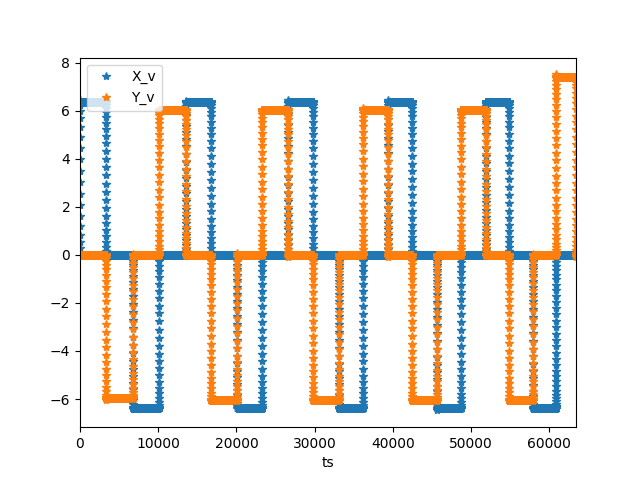

In [123]:
%matplotlib notebook
print(path_k)
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 0:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

#code = p.asg.gen_path_code(pr_opt)
#print(len(code))
#print(code)
            

In [ ]:
path_deltas = []

for i in range(0, 20):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*100,      0, 50])
    path_deltas.append([       0, -k*100, 50])
    path_deltas.append([ -k2*100,      0, 50])
    path_deltas.append([       0, k2*100, 50])

path_deltas